In [1]:
import sklearn

#NN Surrogate model class
from injector_surrogate_quads import *

from emittance_calc import getNormEmit
from sampling_functions import getGroundTruth, getBeamsize

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#BO
from bayes_opt import BayesianOptimization

# Load injector model

In [2]:
Model = Surrogate_NN()

Model.load_saved_model(model_path = '../models/', \
                       model_name = 'modelsmodel_OTR2_NA_rms_emit_elu_2021-07-27T19:54:57-07:00')
Model.load_scaling()
Model.take_log_out = False

energy = 0.135 #GeV

# Set up sampling and objectives

In [3]:
#convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

In [4]:
ref_point = ref_point[0]

In [5]:
#input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','SQ01:b1_gradient','CQ01:b1_gradient','QE04:b1_gradient']

#output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(varx,vary,varz,varscan=[-5,-4,-3,-2,-1,0]): 
    numscan = len(varscan)
    
    #make input array of length model_in_list (inputs model takes)
    x_in = np.empty((numscan,len(Model.model_in_list)))
    
    #fill in reference point around which to optimize
    for i in range(0,len(ref_point)):
        x_in[:,i]=ref_point[i] 

    #set solenoid, SQ, CQ to values from optimization step
    x_in[:, Model.loc_in[opt_var_names[0]]] = varx
    x_in[:, Model.loc_in[opt_var_names[1]]] = vary
    x_in[:, Model.loc_in[opt_var_names[2]]] = varz
    
    #set quad 525 to values for scan
    x_in[:, Model.loc_in[opt_var_names[3]]] = varscan

    #output predictions
    y_out = Model.pred_machine_units(x_in) 
    
    emitx = y_out[:,Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    emity = y_out[:,Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    
    print(f"predicted normemitx {np.mean(emitx)/1e-6:.2f}, normemity {np.mean(emity)/1e-6:.2f}")
    #plt.plot(x_in[:,Model.loc_in['QE04:b1_gradient']],y_out[:,0], label="sig_x")
    #plt.plot(x_in[:,Model.loc_in['QE04:b1_gradient']],y_out[:,1], label="sig_y")
    
    x_rms = y_out[:,0]
    y_rms = y_out[:,1]

    norm_emit = getNormEmit(energy, varscan, x_rms, y_rms) #normalized emittance

    return  norm_emit/1e-6


predicted normemitx 1.23, normemity 1.51
nemitx 1.56 nemity 264185974328.22


/Users/smiskov/opt/anaconda3/envs/injmodel/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/Users/smiskov/opt/anaconda3/envs/injmodel/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


1000000000.0

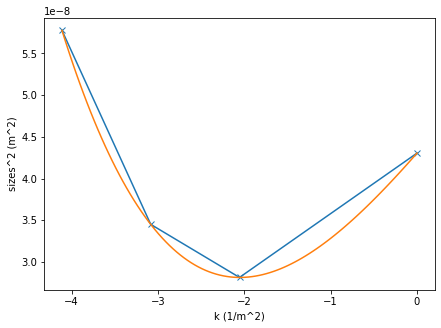

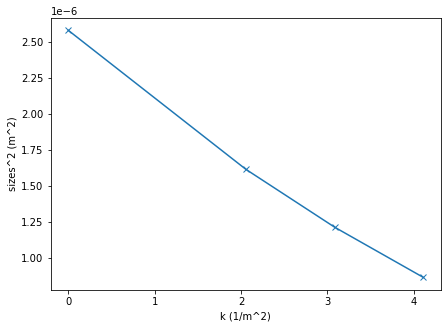

In [9]:
# around x focus
evaluate(0.4657, -0.0071, -0.0169, [ -2, -1.5, -1, 0])



predicted normemitx 1.28, normemity 1.54
nemitx 52.42 nemity 264185974328.22


1000000000.0

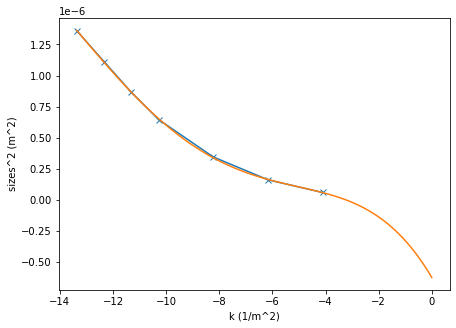

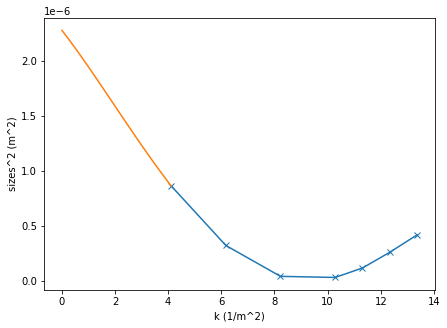

In [28]:
# around y focus
evaluate(0.4657, -0.0071, -0.0169, [ -6.5, -6, -5.5, -5, -4, -3, -2])
